## A Neural Algorithm of Artistic Style 
### Group ID: KMNN
#### Nachiket Paranjape (nmp2139) | Mohneesh Patel (mp3542) | Ketan Mehta (kmm2304)

We take a look at transferring the style patterns of a given image on to another image, with the help of Convolutional Neural Networks. The orginal paper can be found [here](https://arxiv.org/abs/1508.06576). 

The original paper takes uses the `VGG-19` network. In this approach we make use of the following two alternative approaches to the model. 
1. VGG-16
2. AlexNet

In [1]:
import scipy.misc
import numpy as np
import tensorflow as tf
from models import alexnet
from models import vgg
import argparse
import losses
import matplotlib.pyplot as plt 

We will now specify the network we wish to use in the given approach. 

In [2]:
network_model = vgg
#network_model = alexnet

We now create helper functions for loading the image. 

In [24]:
input_content = 'input/1-content.jpg'
input_style = 'styles/style1.jpg'
def load_image(img_path, new_size=None):
    loaded = scipy.misc.imread(img_path).astype(np.float)

    # grayscale to rgb
    if len(loaded.shape) == 2:
        loaded = np.dstack([loaded, loaded, loaded])

    # rescale if needed
    if new_size:
        h,w,c = loaded.shape
        if h > w:
            ratio = w/float(h)
            shape = (new_size, int(new_size*ratio))
        else:
            ratio = h/float(w)
            shape = (int(new_size*ratio), new_size)
        loaded = scipy.misc.imresize(loaded, shape)

    return loaded

def get_name(photo):
    return photo.split('/')[1].split('.')[0]

Define the parameters which will be used for the purpose of training. 

In [33]:
C_LAYER = network_model.content_layers()
S_LAYERS = network_model.style_layers()

content_weight = 1e0
style_weight = 1e5
tv_weight = 0
learning_rate = 1e0

ITERATIONS = 1000
epochs = 1000

Define the images for Style, Content and the Output Path

In [34]:
out = get_name(input_content)+'_'+get_name(input_style)+'.jpg'
style_weight_layer = style_weight/len(S_LAYERS)

content = load_image(input_content, None)
style = load_image(input_style, None)


/home/mp3542/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


Compute layer activations for content and stlye image

In [35]:
# layer activations for content
g = tf.Graph()
with g.as_default(), g.device('/gpu:0'), tf.Session() as sess:
    content_pre = np.array([network_model.preprocess(content)])

    image = tf.placeholder('float', shape=content_pre.shape)
    model = network_model.get_model(image)
    content_out = sess.run(model[C_LAYER], feed_dict = {image:content_pre})

# layer activations for style
g = tf.Graph()
with g.as_default(), g.device('/gpu:0'), tf.Session() as sess:
    style_pre = np.array([network_model.preprocess(style)])
    image = tf.placeholder('float', shape=style_pre.shape)
    model = network_model.get_model(image)
    style_out = sess.run({s_l:model[s_l] for s_l in S_LAYERS}, feed_dict = {image:style_pre})
    

This is the part where we now combine the losses and make use of the optimizer for training purpose. 

0     total loss: 3.73052e+13
50     total loss: 4.38048e+12
100     total loss: 1.55059e+12
150     total loss: 9.66296e+11
200     total loss: 7.16465e+11
250     total loss: 5.7623e+11
300     total loss: 4.85454e+11
350     total loss: 4.21667e+11
400     total loss: 3.74893e+11
450     total loss: 3.38557e+11
500     total loss: 3.09129e+11
550     total loss: 2.84449e+11
600     total loss: 2.63125e+11
650     total loss: 2.44333e+11
700     total loss: 2.27653e+11
750     total loss: 2.12569e+11
800     total loss: 1.98889e+11
850     total loss: 1.86641e+11
900     total loss: 1.75756e+11
950     total loss: 1.6595e+11
  content loss: 8.52472e+10
    style loss: 7.21059e+10
       tv loss: 0
    total loss: 1.57353e+11


/home/mp3542/.local/lib/python3.5/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


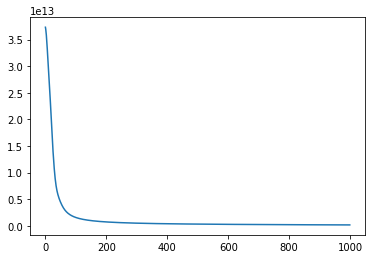

In [36]:
loss_plot = []
g = tf.Graph()
with g.as_default(), g.device('/gpu:0'), tf.Session() as sess:
    
    target = tf.random_normal((1,)+content.shape)

    target_pre_var = tf.Variable(target)

    model = network_model.get_model(target_pre_var)

    ## compute the loss
    cont_cost = losses.content_loss(content_out, model, C_LAYER, content_weight)
    style_cost = losses.style_loss(style_out, model, S_LAYERS, style_weight_layer)
    tv_cost = losses.total_var_loss(target_pre_var, tv_weight)

    total_loss = cont_cost + tf.add_n(style_cost) + tv_cost

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)

    sess.run(tf.initialize_all_variables())
    min_loss = float("inf")
    best = None
    for i in range(epochs):
        train_step.run()

        if (i%50 == 0):
            loss = total_loss.eval()
            print(i , '    total loss: %g' % total_loss.eval())
            if(loss < min_loss):
                min_loss = loss
                best = target_pre_var.eval()
        loss_plot.append(total_loss.eval())

    print('  content loss: %g' % cont_cost.eval())
    print('    style loss: %g' % tf.add_n(style_cost).eval())
    print('       tv loss: %g' % tv_cost.eval())
    print('    total loss: %g' % total_loss.eval())
    
    
    final = best
    final = final.squeeze()
    final = network_model.postprocess(final)

    final = np.clip(final, 0, 255).astype(np.uint8)
    scipy.misc.imsave(out, final)

plt.plot(loss_plot)
plt.show()